In [1]:
!pip install --upgrade pip
!pip install ipykernel
!pip install seaborn
!pip install pandas


Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In [2]:
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.4.2
!pip install scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (11.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

In [4]:
# Training the Model

main_voc_df = pd.read_csv('final_trainingset_fixed.csv')  
X = main_voc_df.drop(columns=['Label'])
y = main_voc_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

svm_classifier = SVC(
    class_weight='balanced',
    random_state=42
)

model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None)),
    ('classifier', svm_classifier)
])

param_grid = {
    'classifier__kernel': ['rbf', 'poly'],
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10],
    'classifier__degree': [2, 3, 4],
    'pca__n_components': [2, 3],
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_



In [5]:

joblib.dump(best_model, 'svm_best_model.joblib')
print('Model saved as svm_best_model.joblib.')

Model saved as svm_best_model.joblib.


/tmp/ipykernel_4900/130573307.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


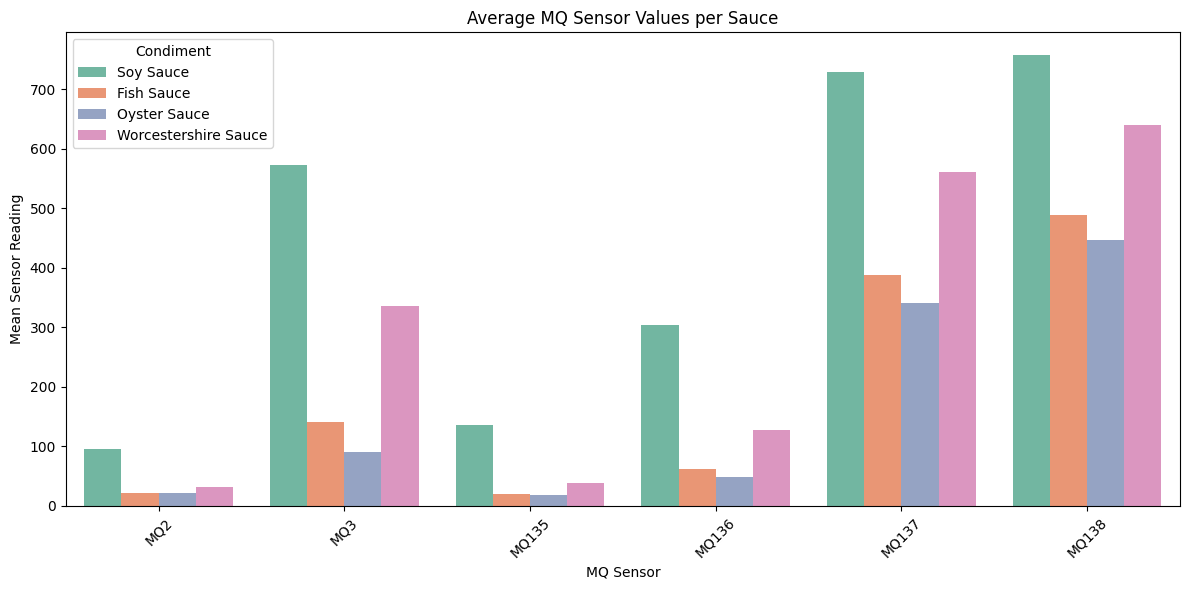

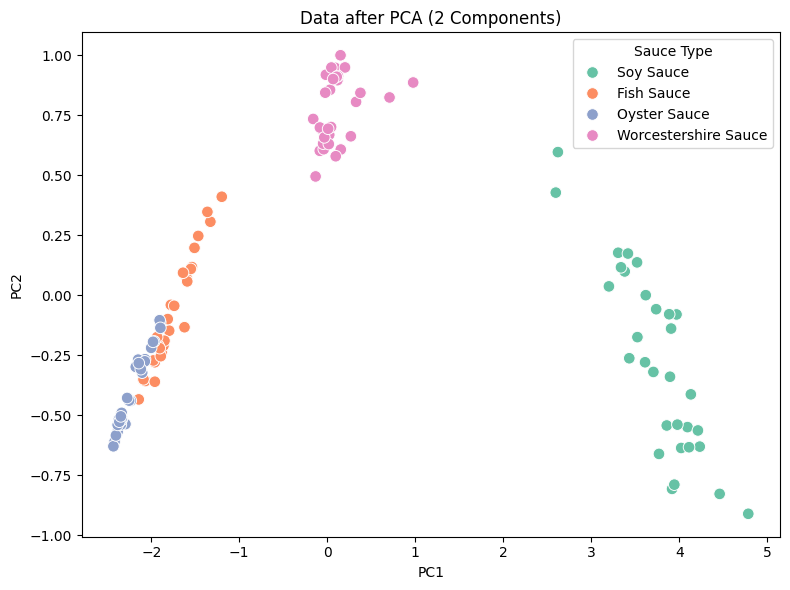

In [6]:
melted_df = main_voc_df.melt(
    id_vars="Label",
    value_vars=[col for col in main_voc_df.columns if "MQ" in col],
    var_name="Sensor",
    value_name="Value"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_df,
    x="Sensor",
    y="Value",
    hue="Label",
    ci=None,
    palette="Set2"
)

plt.title("Average MQ Sensor Values per Sauce")
plt.ylabel("Mean Sensor Reading")
plt.xlabel("MQ Sensor")
plt.xticks(rotation=45)
plt.legend(title="Condiment")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df['Label'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Label", palette="Set2", s=70)
plt.title("Data after PCA (2 Components)")
plt.legend(title="Sauce Type")
plt.tight_layout()
plt.show()


Best Hyperparameters:


,Hyperparameter,Value
0,classifier__C,0.1
1,classifier__degree,3
2,classifier__gamma,10
3,classifier__kernel,poly
4,pca__n_components,2



Evaluation Metrics (Unseen Data):


,Metric,Value
0,Accuracy,0.9917
1,Macro F1 Score,0.9917



Classification Report:
                      precision    recall  f1-score   support

           Soy Sauce       0.97      1.00      0.98        30
          Fish Sauce       1.00      0.97      0.98        30
        Oyster Sauce       1.00      1.00      1.00        31
Worcestershire Sauce       1.00      1.00      1.00        30

            accuracy                           0.99       121
           macro avg       0.99      0.99      0.99       121
        weighted avg       0.99      0.99      0.99       121



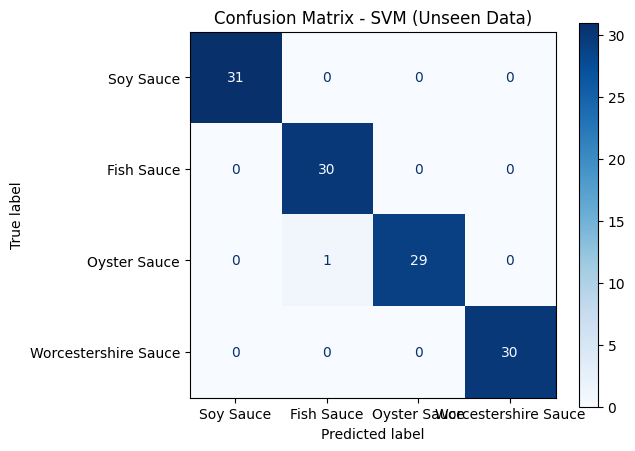


Misclassified Trials:


,True Label,Predicted Label,Correct
89,Oyster Sauce,Fish Sauce,False



All Predictions:


,True Label,Predicted Label,Correct
0,Soy Sauce,Soy Sauce,True
1,Soy Sauce,Soy Sauce,True
2,Soy Sauce,Soy Sauce,True
3,Soy Sauce,Soy Sauce,True
4,Soy Sauce,Soy Sauce,True
...,...,...,...
116,Worcestershire Sauce,Worcestershire Sauce,True
117,Worcestershire Sauce,Worcestershire Sauce,True
118,Worcestershire Sauce,Worcestershire Sauce,True
119,Worcestershire Sauce,Worcestershire Sauce,True


In [7]:
new_df = pd.read_csv('final_trainingset_fixed.csv')
X_new = new_df.drop(columns=['Label'])
Y_new = new_df['Label']

predictions = best_model.predict(X_new)

accuracy = accuracy_score(Y_new, predictions)
f1_macro = f1_score(Y_new, predictions, average='macro')

best_params_df = pd.DataFrame(
    list(grid_search.best_params_.items()),
    columns=['Hyperparameter', 'Value']
)
print("\nBest Hyperparameters:")
display(best_params_df)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1 Score'],
    'Value': [f"{accuracy:.4f}", f"{f1_macro:.4f}"]
})
print("\nEvaluation Metrics (Unseen Data):")
display(metrics_df)

print("\nClassification Report:")
print(classification_report(Y_new, predictions, target_names=Y_new.unique()))

labels = Y_new.unique()  # Preserves label order from CSV
conf_matrix = confusion_matrix(Y_new, predictions, labels=labels)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM (Unseen Data)")
plt.tight_layout()
plt.show()


results_df = pd.DataFrame({
    'True Label': Y_new,
    'Predicted Label': predictions
})
results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

misclassified = results_df[~results_df['Correct']]

print("\nMisclassified Trials:")
display(misclassified)

print("\nAll Predictions:")
display(results_df)
#